# Clasificación de impagos de préstamos en un banco

Vamos a implementar un modelo para detectar impagos en los préstamos de un banco

## Índice

1. [Conexión a la base de datos](#mysql)
2. [Feature Extraction](#feature_extraction)
4. [Feature selection](#correlation)
5. [Transformation](#transformation)
6. [Modeling](#modeling)
7. [Feature Importance](#feature_importance)
8. [Próximos pasos](#future)

<a name='mysql'></a>
## 1. Conexión a la base de datos

In [3]:
import pymysql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
database_host = 'relational.fit.cvut.cz'
username = 'guest'
password = 'relational'
database_name = 'financial'

db = pymysql.connect(host = database_host,
                     user = username,
                     password = password,
                     database = database_name)

In [5]:
query = "SELECT * FROM loan"
df = pd.read_sql(query,db)
df

,loan_id,account_id,date,amount,duration,payments,status
0,4959,2,1994-01-05,80952,24,3373.0,A
1,4961,19,1996-04-29,30276,12,2523.0,B
2,4962,25,1997-12-08,30276,12,2523.0,A
3,4967,37,1998-10-14,318480,60,5308.0,D
4,4968,38,1998-04-19,110736,48,2307.0,C
...,...,...,...,...,...,...,...
677,7294,11327,1998-09-27,39168,24,1632.0,C
678,7295,11328,1998-07-18,280440,60,4674.0,C
679,7304,11349,1995-10-29,419880,60,6998.0,C
680,7305,11359,1996-08-06,54024,12,4502.0,A


<a name='feature_extraction'></a>
## 2. Extracción de variables

De las tablas **loan**, **account** y **district** extrae las siguientes variables en una única tabla
- identificador de la cuenta
- fecha del préstamo
- cantidad del préstamo
- duración del préstamo
- pagos mensuales
- estado del préstamo
- frecuencia de los extractos bancarios
- fecha de creación de la cuenta
- nº de habitantes del distrito
- variables del distrito (A4, A11, A12, A13, A14, A15, A16)

In [6]:
query = '''
SELECT  loan.account_id,
        loan.date as date_loan,
        amount,
        duration,
        payments,
        status,
        frequency,
        account.date as date_acc,
        A4, A11, A12, A13, A14, A15, A16
FROM loan
JOIN account
ON loan.account_id = account.account_id
JOIN district
ON account.district_id = district.district_id
'''

df = pd.read_sql(query,db)
df

,account_id,date_loan,amount,duration,payments,status,frequency,date_acc,A4,A11,A12,A13,A14,A15,A16
0,2,1994-01-05,80952,24,3373.0,A,POPLATEK MESICNE,1993-02-26,1204953,12541,0.2,0.43,167,85677.0,99107
1,19,1996-04-29,30276,12,2523.0,B,POPLATEK MESICNE,1995-04-07,103347,9104,1.5,2.07,123,2299.0,2354
2,25,1997-12-08,30276,12,2523.0,A,POPLATEK MESICNE,1996-07-28,228848,9893,4.0,4.72,96,5623.0,5887
3,37,1998-10-14,318480,60,5308.0,D,POPLATEK MESICNE,1997-08-18,70646,8547,2.6,3.64,120,1563.0,1542
4,38,1998-04-19,110736,48,2307.0,C,POPLATEK TYDNE,1997-08-08,51428,8402,3.1,3.98,120,999.0,1099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,11327,1998-09-27,39168,24,1632.0,C,POPLATEK MESICNE,1997-10-15,94725,9920,2.2,2.87,130,4289.0,4846
678,11328,1998-07-18,280440,60,4674.0,C,POPLATEK MESICNE,1996-11-05,387570,9897,1.6,1.96,140,18721.0,18696
679,11349,1995-10-29,419880,60,6998.0,C,POPLATEK TYDNE,1995-05-26,1204953,12541,0.2,0.43,167,85677.0,99107
680,11359,1996-08-06,54024,12,4502.0,A,POPLATEK MESICNE,1994-10-01,117897,8814,4.7,5.74,107,2112.0,2059


Transforma las fechas con `pandas.to_datetime`

In [7]:
df['date_loan'] = pd.to_datetime(df.date_loan, format='%Y-%m-%d')
df['date_acc'] = pd.to_datetime(df.date_acc, format='%Y-%m-%d')

Crea la variable `days_between` como la diferencia de días entre la fecha del préstamo y la fecha creación de la cuenta

In [8]:
df['days_between'] = (df['date_loan'] - df['date_acc']).dt.days

Renombra las variables relacionadas con el distrito y crea la variable del ratio de crímenes por habitante

In [9]:
df['n_inhabitants'] = df.A4
df['average_salary'] = df.A11
df['average_unemployment_rate'] = df[['A12', 'A13']].mean(axis=1)
df['entrepreneur_rate'] = df['A14']
df['average_crime_rate'] = df[['A15', 'A16']].mean(axis=1) / df['n_inhabitants']

Crea el target binario

In [10]:
df['target'] = (df['status'] == 'B') | (df['status'] == 'D')

In [11]:
df

,account_id,date_loan,amount,duration,payments,status,frequency,date_acc,A4,A11,...,A14,A15,A16,days_between,n_inhabitants,average_salary,average_unemployment_rate,entrepreneur_rate,average_crime_rate,target
0,2,1994-01-05,80952,24,3373.0,A,POPLATEK MESICNE,1993-02-26,1204953,12541,...,167,85677.0,99107,313,1204953,12541,0.315,167,0.076677,False
1,19,1996-04-29,30276,12,2523.0,B,POPLATEK MESICNE,1995-04-07,103347,9104,...,123,2299.0,2354,388,103347,9104,1.785,123,0.022512,True
2,25,1997-12-08,30276,12,2523.0,A,POPLATEK MESICNE,1996-07-28,228848,9893,...,96,5623.0,5887,498,228848,9893,4.360,96,0.025148,False
3,37,1998-10-14,318480,60,5308.0,D,POPLATEK MESICNE,1997-08-18,70646,8547,...,120,1563.0,1542,422,70646,8547,3.120,120,0.021976,True
4,38,1998-04-19,110736,48,2307.0,C,POPLATEK TYDNE,1997-08-08,51428,8402,...,120,999.0,1099,254,51428,8402,3.540,120,0.020397,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,11327,1998-09-27,39168,24,1632.0,C,POPLATEK MESICNE,1997-10-15,94725,9920,...,130,4289.0,4846,347,94725,9920,2.535,130,0.048219,False
678,11328,1998-07-18,280440,60,4674.0,C,POPLATEK MESICNE,1996-11-05,387570,9897,...,140,18721.0,18696,620,387570,9897,1.780,140,0.048271,False
679,11349,1995-10-29,419880,60,6998.0,C,POPLATEK TYDNE,1995-05-26,1204953,12541,...,167,85677.0,99107,156,1204953,12541,0.315,167,0.076677,False
680,11359,1996-08-06,54024,12,4502.0,A,POPLATEK MESICNE,1994-10-01,117897,8814,...,107,2112.0,2059,675,117897,8814,5.220,107,0.017689,False


In [12]:
df.account_id.nunique()

682

De la tabla **trans** obtén, para cada cuenta, la cantidad transferida y el balance

In [13]:
query = '''
select trans.account_id, trans.amount as trans_amount, balance as trans_balance 
from trans
join loan
on trans.account_id = loan.account_id
and trans.date < loan.date
'''
df_trans = pd.read_sql(query,db)
df_trans

,account_id,trans_amount,trans_balance
0,2,1100,1100
1,2,20236,21336
2,2,20236,45286
3,2,20236,54631
4,2,30354,67530
...,...,...,...
54689,11362,93,17922
54690,11362,75,14889
54691,11362,73,15993
54692,11362,87,19331


Cuenta el número de transacciones de cada cuenta

In [14]:
# account_id | n_trans
#    2          54
n_trans = df_trans[['account_id', 'trans_amount']].groupby('account_id',as_index=False).count()
n_trans.columns = ['account_id', 'n_trans']
n_trans

,account_id,n_trans
0,2,54
1,19,80
2,25,164
3,37,116
4,38,55
...,...,...
677,11327,54
678,11328,106
679,11349,18
680,11359,147


Calcula la media de cantidad y balance de las transacciones para cada cuenta

In [15]:
df_trans2 = df_trans.groupby('account_id',as_index=False).mean()
df_trans2

,account_id,trans_amount,trans_balance
0,2,7954.333333,32590.759259
1,19,5856.350000,25197.137500
2,25,12113.981707,62991.408537
3,37,7572.034483,39954.034483
4,38,4716.200000,31383.581818
...,...,...,...
677,11327,7977.981481,55438.814815
678,11328,8138.754717,38619.084906
679,11349,24426.500000,59352.666667
680,11359,8708.775510,36480.238095


Une todos estos datos con el dataframe general

In [16]:
df = df.merge(df_trans2,how='left',left_on='account_id',right_on='account_id').merge(n_trans,how='left',left_on='account_id',right_on='account_id')
df

,account_id,date_loan,amount,duration,payments,status,frequency,date_acc,A4,A11,...,days_between,n_inhabitants,average_salary,average_unemployment_rate,entrepreneur_rate,average_crime_rate,target,trans_amount,trans_balance,n_trans
0,2,1994-01-05,80952,24,3373.0,A,POPLATEK MESICNE,1993-02-26,1204953,12541,...,313,1204953,12541,0.315,167,0.076677,False,7954.333333,32590.759259,54
1,19,1996-04-29,30276,12,2523.0,B,POPLATEK MESICNE,1995-04-07,103347,9104,...,388,103347,9104,1.785,123,0.022512,True,5856.350000,25197.137500,80
2,25,1997-12-08,30276,12,2523.0,A,POPLATEK MESICNE,1996-07-28,228848,9893,...,498,228848,9893,4.360,96,0.025148,False,12113.981707,62991.408537,164
3,37,1998-10-14,318480,60,5308.0,D,POPLATEK MESICNE,1997-08-18,70646,8547,...,422,70646,8547,3.120,120,0.021976,True,7572.034483,39954.034483,116
4,38,1998-04-19,110736,48,2307.0,C,POPLATEK TYDNE,1997-08-08,51428,8402,...,254,51428,8402,3.540,120,0.020397,False,4716.200000,31383.581818,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,11327,1998-09-27,39168,24,1632.0,C,POPLATEK MESICNE,1997-10-15,94725,9920,...,347,94725,9920,2.535,130,0.048219,False,7977.981481,55438.814815,54
678,11328,1998-07-18,280440,60,4674.0,C,POPLATEK MESICNE,1996-11-05,387570,9897,...,620,387570,9897,1.780,140,0.048271,False,8138.754717,38619.084906,106
679,11349,1995-10-29,419880,60,6998.0,C,POPLATEK TYDNE,1995-05-26,1204953,12541,...,156,1204953,12541,0.315,167,0.076677,False,24426.500000,59352.666667,18
680,11359,1996-08-06,54024,12,4502.0,A,POPLATEK MESICNE,1994-10-01,117897,8814,...,675,117897,8814,5.220,107,0.017689,False,8708.775510,36480.238095,147


De la tabla **card**, añade el tipo de tarjeta para cada cuenta (solo titulares)

In [17]:
query='''
select disp.account_id, card.type as card_type

from card
join disp 
on card.disp_id = disp.disp_id
join loan
on disp.account_id = loan.account_id
and card.issued < loan.date
WHERE disp.type = 'OWNER'
'''
df_card = pd.read_sql(query,db)
df_card

,account_id,card_type
0,105,classic
1,226,classic
2,276,classic
3,544,classic
4,666,classic
5,1480,classic
6,1766,classic
7,1869,classic
8,2116,classic
9,2262,classic


Une la tabla anterior a la general. Para aquellas cuentas sin tarjeta, ponle el valor "No"

In [22]:
df = df.merge(df_card, how='left', left_on='account_id',right_on='account_id')
df['card_type'].fillna('No',inplace=True)
df

,account_id,date_loan,amount,duration,payments,status,frequency,date_acc,A4,A11,...,n_inhabitants,average_salary,average_unemployment_rate,entrepreneur_rate,average_crime_rate,target,trans_amount,trans_balance,n_trans,card_type
0,2,1994-01-05,80952,24,3373.0,A,POPLATEK MESICNE,1993-02-26,1204953,12541,...,1204953,12541,0.315,167,0.076677,False,7954.333333,32590.759259,54,No
1,19,1996-04-29,30276,12,2523.0,B,POPLATEK MESICNE,1995-04-07,103347,9104,...,103347,9104,1.785,123,0.022512,True,5856.350000,25197.137500,80,No
2,25,1997-12-08,30276,12,2523.0,A,POPLATEK MESICNE,1996-07-28,228848,9893,...,228848,9893,4.360,96,0.025148,False,12113.981707,62991.408537,164,No
3,37,1998-10-14,318480,60,5308.0,D,POPLATEK MESICNE,1997-08-18,70646,8547,...,70646,8547,3.120,120,0.021976,True,7572.034483,39954.034483,116,No
4,38,1998-04-19,110736,48,2307.0,C,POPLATEK TYDNE,1997-08-08,51428,8402,...,51428,8402,3.540,120,0.020397,False,4716.200000,31383.581818,55,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,11327,1998-09-27,39168,24,1632.0,C,POPLATEK MESICNE,1997-10-15,94725,9920,...,94725,9920,2.535,130,0.048219,False,7977.981481,55438.814815,54,No
678,11328,1998-07-18,280440,60,4674.0,C,POPLATEK MESICNE,1996-11-05,387570,9897,...,387570,9897,1.780,140,0.048271,False,8138.754717,38619.084906,106,No
679,11349,1995-10-29,419880,60,6998.0,C,POPLATEK TYDNE,1995-05-26,1204953,12541,...,1204953,12541,0.315,167,0.076677,False,24426.500000,59352.666667,18,No
680,11359,1996-08-06,54024,12,4502.0,A,POPLATEK MESICNE,1994-10-01,117897,8814,...,117897,8814,5.220,107,0.017689,False,8708.775510,36480.238095,147,classic


De la tabla **client**, obtén la edad de los clientes (en el momento del préstamo), su sexo y añade una variable binaria que indique si el distrito del cliente coincide con el distrito de la cuenta

In [25]:
query = '''
SELECT account_id, 
        loan.date as loan_date,
        account.district_id as acc_dist_id,
        client.district_id as cli_dist_id,
        gender as owner_gender,
        birth_date

FROM loan
join account using(account_id)
join disp using(account_id)
join client using(client_id)

where disp.type='OWNER'
'''
df_cli = pd.read_sql(query,db)
df_cli

,account_id,loan_date,acc_dist_id,cli_dist_id,owner_gender,birth_date
0,2,1994-01-05,1,1,M,1945-02-04
1,19,1996-04-29,21,21,F,1939-04-23
2,25,1997-12-08,68,68,M,1962-02-09
3,37,1998-10-14,20,20,M,1952-08-26
4,38,1998-04-19,19,19,F,1940-01-30
...,...,...,...,...,...,...
677,11327,1998-09-27,7,7,F,1979-02-22
678,11328,1998-07-18,54,54,F,1952-09-09
679,11349,1995-10-29,1,1,F,1945-10-30
680,11359,1996-08-06,61,61,M,1968-04-13


In [27]:
df_cli['same_district'] = df_cli['acc_dist_id'] == df_cli['cli_dist_id']
df_cli['loan_date'] = pd.to_datetime(df_cli['loan_date'],
                                     format='%Y-%m-%d')
df_cli['birth_date'] = pd.to_datetime(df_cli['birth_date'],
                                     format='%Y-%m-%d')
df_cli['owner_age'] =  (df_cli['loan_date']-df_cli['birth_date']).astype('<m8[Y]')
df_cli['owner_age2'] =  (df_cli['loan_date']-df_cli['birth_date']).dt.days // 365

In [28]:
df_cli

,account_id,loan_date,acc_dist_id,cli_dist_id,owner_gender,birth_date,same_district,owner_age,owner_age2
0,2,1994-01-05,1,1,M,1945-02-04,True,48.0,48
1,19,1996-04-29,21,21,F,1939-04-23,True,57.0,57
2,25,1997-12-08,68,68,M,1962-02-09,True,35.0,35
3,37,1998-10-14,20,20,M,1952-08-26,True,46.0,46
4,38,1998-04-19,19,19,F,1940-01-30,True,58.0,58
...,...,...,...,...,...,...,...,...,...
677,11327,1998-09-27,7,7,F,1979-02-22,True,19.0,19
678,11328,1998-07-18,54,54,F,1952-09-09,True,45.0,45
679,11349,1995-10-29,1,1,F,1945-10-30,True,49.0,50
680,11359,1996-08-06,61,61,M,1968-04-13,True,28.0,28


Une la tabla anterior con la general

In [29]:
df = df.merge(df_cli,left_on='account_id',right_on='account_id')
df

,account_id,date_loan,amount,duration,payments,status,frequency,date_acc,A4,A11,...,n_trans,card_type,loan_date,acc_dist_id,cli_dist_id,owner_gender,birth_date,same_district,owner_age,owner_age2
0,2,1994-01-05,80952,24,3373.0,A,POPLATEK MESICNE,1993-02-26,1204953,12541,...,54,No,1994-01-05,1,1,M,1945-02-04,True,48.0,48
1,19,1996-04-29,30276,12,2523.0,B,POPLATEK MESICNE,1995-04-07,103347,9104,...,80,No,1996-04-29,21,21,F,1939-04-23,True,57.0,57
2,25,1997-12-08,30276,12,2523.0,A,POPLATEK MESICNE,1996-07-28,228848,9893,...,164,No,1997-12-08,68,68,M,1962-02-09,True,35.0,35
3,37,1998-10-14,318480,60,5308.0,D,POPLATEK MESICNE,1997-08-18,70646,8547,...,116,No,1998-10-14,20,20,M,1952-08-26,True,46.0,46
4,38,1998-04-19,110736,48,2307.0,C,POPLATEK TYDNE,1997-08-08,51428,8402,...,55,No,1998-04-19,19,19,F,1940-01-30,True,58.0,58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,11327,1998-09-27,39168,24,1632.0,C,POPLATEK MESICNE,1997-10-15,94725,9920,...,54,No,1998-09-27,7,7,F,1979-02-22,True,19.0,19
678,11328,1998-07-18,280440,60,4674.0,C,POPLATEK MESICNE,1996-11-05,387570,9897,...,106,No,1998-07-18,54,54,F,1952-09-09,True,45.0,45
679,11349,1995-10-29,419880,60,6998.0,C,POPLATEK TYDNE,1995-05-26,1204953,12541,...,18,No,1995-10-29,1,1,F,1945-10-30,True,49.0,50
680,11359,1996-08-06,54024,12,4502.0,A,POPLATEK MESICNE,1994-10-01,117897,8814,...,147,classic,1996-08-06,61,61,M,1968-04-13,True,28.0,28


### Tablón final

In [30]:
df_ml = df[['amount', 'duration', 'payments', 'days_between', 'n_inhabitants', 
            'average_salary', 'average_unemployment_rate', 'entrepreneur_rate', 
            'average_crime_rate','trans_amount','trans_balance',
            'n_trans', 'owner_age', 
            'frequency', 'card_type', 'same_district', 'owner_gender', 'target']]

In [31]:
df_ml.sample(4)

,amount,duration,payments,days_between,n_inhabitants,average_salary,average_unemployment_rate,entrepreneur_rate,average_crime_rate,trans_amount,trans_balance,n_trans,owner_age,frequency,card_type,same_district,owner_gender,target
101,57360,12,4780.0,313,77963,8546,3.460,126,0.036941,8336.613333,36887.066667,75,39.0,POPLATEK MESICNE,No,True,M,True
263,66696,24,2779.0,110,1204953,12541,0.315,167,0.076677,10860.625000,58360.812500,16,22.0,POPLATEK MESICNE,No,True,M,False
243,327660,60,5461.0,660,85852,8965,7.615,104,0.031886,11424.523810,49281.896825,126,56.0,POPLATEK MESICNE,No,True,F,False
447,27984,12,2332.0,519,139012,8363,2.995,108,0.019290,7289.618421,30639.973684,76,46.0,POPLATEK TYDNE,No,True,M,False


In [33]:
df_ml.isnull().sum()

amount                       0
duration                     0
payments                     0
days_between                 0
n_inhabitants                0
average_salary               0
average_unemployment_rate    0
entrepreneur_rate            0
average_crime_rate           0
trans_amount                 0
trans_balance                0
n_trans                      0
owner_age                    0
frequency                    0
card_type                    0
same_district                0
owner_gender                 0
target                       0
dtype: int64

<a name='transformation'></a>
## 3. Transformaciones

Convierte las categóricas mediante one-hot encoding

In [46]:
df_ml2 = pd.get_dummies(df_ml,columns=['frequency','card_type'])
df_ml2['same_district'] = df_ml2.same_district.astype('int')
df_ml2['target'] = df_ml2.target.astype('int')
df_ml2['owner_gender'] = df_ml2.owner_gender.map({'F':1, 'M':0})
df_ml2.head()

,amount,duration,payments,days_between,n_inhabitants,average_salary,average_unemployment_rate,entrepreneur_rate,average_crime_rate,trans_amount,...,same_district,owner_gender,target,frequency_POPLATEK MESICNE,frequency_POPLATEK PO OBRATU,frequency_POPLATEK TYDNE,card_type_No,card_type_classic,card_type_gold,card_type_junior
0,80952,24,3373.0,313,1204953,12541,0.315,167,0.076677,7954.333333,...,1,0,0,1,0,0,1,0,0,0
1,30276,12,2523.0,388,103347,9104,1.785,123,0.022512,5856.350000,...,1,1,1,1,0,0,1,0,0,0
2,30276,12,2523.0,498,228848,9893,4.360,96,0.025148,12113.981707,...,1,0,0,1,0,0,1,0,0,0
3,318480,60,5308.0,422,70646,8547,3.120,120,0.021976,7572.034483,...,1,0,1,1,0,0,1,0,0,0
4,110736,48,2307.0,254,51428,8402,3.540,120,0.020397,4716.200000,...,1,1,0,0,0,1,1,0,0,0


In [47]:
df_ml2.describe()

,amount,duration,payments,days_between,n_inhabitants,average_salary,average_unemployment_rate,entrepreneur_rate,average_crime_rate,trans_amount,...,same_district,owner_gender,target,frequency_POPLATEK MESICNE,frequency_POPLATEK PO OBRATU,frequency_POPLATEK TYDNE,card_type_No,card_type_classic,card_type_gold,card_type_junior
count,682.000000,682.000000,682.000000,682.000000,6.820000e+02,682.000000,682.000000,682.000000,682.000000,682.000000,...,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000
mean,151410.175953,36.492669,4190.664223,398.240469,2.720522e+05,9502.986804,3.209729,121.218475,0.036224,9488.694238,...,0.912023,0.510264,0.111437,0.819648,0.046921,0.133431,0.947214,0.041056,0.004399,0.007331
std,113372.406310,17.075219,2215.830344,164.611359,3.583320e+05,1323.150982,2.029293,23.366091,0.018186,4445.464366,...,0.283469,0.500262,0.314903,0.384762,0.211624,0.340290,0.223770,0.198565,0.066226,0.085372
min,4980.000000,12.000000,304.000000,102.000000,4.282100e+04,8110.000000,0.315000,81.000000,0.014744,1566.921212,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,66732.000000,24.000000,2477.000000,261.250000,9.208400e+04,8544.000000,1.780000,106.000000,0.022194,6021.832603,...,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,116928.000000,36.000000,3934.000000,395.500000,1.246050e+05,8991.000000,3.075000,116.000000,0.031713,8942.016026,...,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,210654.000000,48.000000,5813.500000,528.750000,2.261220e+05,9897.000000,4.360000,132.000000,0.042703,12557.855482,...,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,590820.000000,60.000000,9910.000000,697.000000,1.204953e+06,12541.000000,8.350000,167.000000,0.076677,26978.866667,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<a name='train-test'></a>
## 4. División train-test

In [48]:
X = df_ml2.drop(columns=['target'])
y = df_ml2['target']

In [49]:
from sklearn.model_selection import train_test_split

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1,stratify=y)

In [51]:
X_train.shape, X_test.shape

((477, 22), (205, 22))

In [55]:
y_train.value_counts()

0    424
1     53
Name: target, dtype: int64

In [71]:
# SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_resample(X_train, y_train)

In [72]:
y_sm.value_counts()

0    424
1    424
Name: target, dtype: int64

<a name='correlation'></a>
## 5. Selección de variables

Aplica técnicas para seleccionar las variables de entrada al modelo

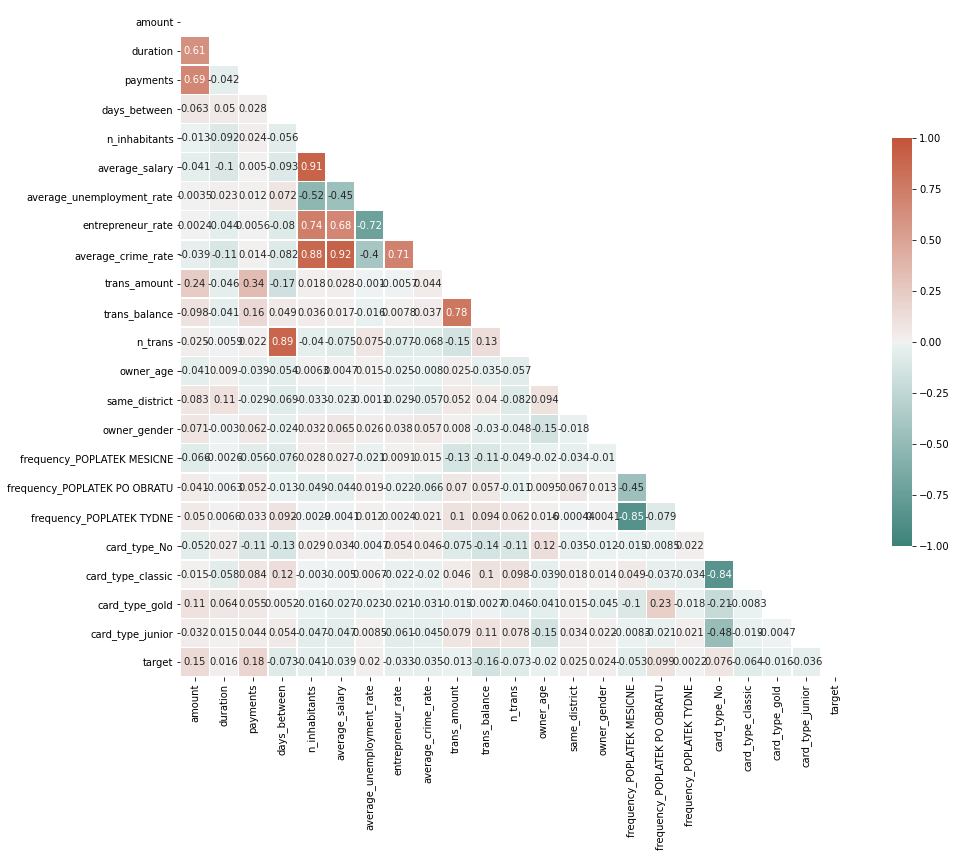

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

correlation = pd.concat([X_train,y_train],axis=1).corr() 

mask = np.zeros_like(correlation, dtype=bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(15, 15))

cmap = sns.diverging_palette(180, 20, as_cmap=True)
sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=1, vmin =-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

<AxesSubplot:xlabel='average_crime_rate', ylabel='average_salary'>

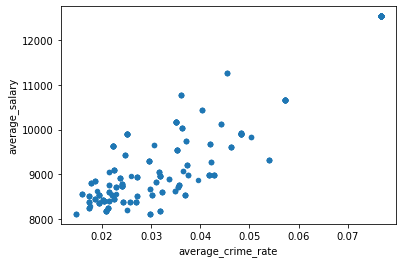

In [59]:
X_train.plot.scatter(x='average_crime_rate',y='average_salary')

In [61]:
from sklearn.feature_selection import SelectKBest, f_classif

sel = SelectKBest(f_classif,k=5)
X_new = sel.fit_transform(X_train,y_train)
print(X_new.shape)
pd.DataFrame({'column':X_train.columns, 'score':sel.scores_}).sort_values('score',ascending=False)

(477, 5)


,column,score
2,payments,16.384244
10,trans_balance,11.796571
0,amount,11.651313
16,frequency_POPLATEK PO OBRATU,4.657673
18,card_type_No,2.750207
3,days_between,2.534275
11,n_trans,2.525856
19,card_type_classic,1.935615
15,frequency_POPLATEK MESICNE,1.353276
4,n_inhabitants,0.780698


In [110]:
from sklearn.ensemble import RandomForestClassifier

rf =RandomForestClassifier(n_estimators = 100)
rf.fit(X_train, y_train)

scores = sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), X_train.columns), reverse=True)
pd.DataFrame(scores, columns=['Score', 'Feature'])

,Score,Feature
0,0.1195,payments
1,0.1170,trans_balance
2,0.0970,n_trans
3,0.0960,amount
4,0.0797,days_between
5,0.0751,trans_amount
6,0.0748,owner_age
7,0.0592,average_salary
8,0.0566,n_inhabitants
9,0.0507,average_unemployment_rate


<a name='modeling'></a>
## 6. Modelado

Entrena uno o varios modelos, dividiendo el conjunto en train-test 

In [73]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

estimator = XGBClassifier(seed=42)

parameters = {
 'max_depth':[3],
 'min_child_weight':[3],
 'gamma':[0.2],
 'subsample':[0.9],
 'colsample_bytree':[0.5],
 'reg_alpha':[1e-3]
}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'f1',
    n_jobs = -1,
    cv = 10,
    verbose=1
)

grid_search.fit(X_sm, y_sm)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  2.3min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.4min finished
C:\Users\rzambrano\Anaconda3\envs\general\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:29:00] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, seed=42,
                                     subsample=None, tree_me

In [65]:
grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0.001, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [66]:
grid_search.best_score_

0.1488095238095238

In [67]:
grid_search.best_estimator_.score(X_test,y_test)

0.8731707317073171

### Medición del desempeño

Utiliza las méticas de desempeño de los modelos de clasificación binarios, en el conjunto de train y test

In [74]:
ypred = grid_search.best_estimator_.predict(X_test)
ypred

array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0])

In [75]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, ypred))
confusion_matrix(y_test, ypred)

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       182
           1       0.26      0.26      0.26        23

    accuracy                           0.83       205
   macro avg       0.58      0.58      0.58       205
weighted avg       0.83      0.83      0.83       205



array([[165,  17],
       [ 17,   6]], dtype=int64)

In [70]:
y_test.value_counts()

0    182
1     23
Name: target, dtype: int64

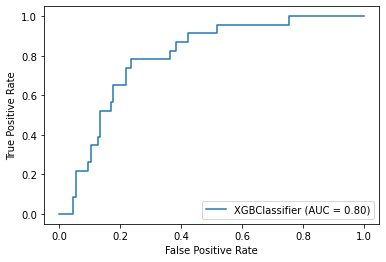

In [76]:
from sklearn import metrics
metrics.plot_roc_curve(grid_search.best_estimator_, X_test,y_test)

### Do it yourself

1. Calcula el accuracy para el TOP 10% de clientes según el score del modelo
2. Implementa un modelo de propensión a contratar préstamos

In [79]:
ypred_prob = grid_search.best_estimator_.predict_proba(X_test)[:,1]
ypred_prob

array([7.94857740e-01, 2.92406278e-03, 6.58871024e-04, 5.47787771e-02,
       4.67963666e-01, 4.64405399e-03, 5.18639870e-02, 6.50203288e-01,
       3.71056125e-02, 6.42591417e-02, 4.71958518e-02, 1.61432605e-02,
       8.36748660e-01, 5.22426236e-03, 1.57562438e-02, 7.87862897e-01,
       2.48551778e-02, 4.79395062e-01, 9.50537547e-02, 1.01654813e-01,
       1.96841615e-03, 6.71042427e-02, 1.44863259e-02, 6.53349534e-02,
       5.69618447e-03, 4.98554081e-01, 2.98475437e-02, 1.32006658e-02,
       2.33851820e-01, 7.18463600e-01, 7.78046668e-01, 8.93417716e-01,
       4.45848011e-04, 3.90911326e-02, 1.22536137e-03, 6.53850317e-01,
       6.42754287e-02, 7.35487714e-02, 1.95659176e-02, 4.60401597e-03,
       1.47755607e-03, 5.88910282e-01, 1.01303769e-04, 2.57677697e-02,
       2.76428554e-02, 2.29294528e-03, 9.07550380e-02, 3.55124474e-02,
       1.52796507e-03, 9.85359102e-02, 3.99899669e-02, 7.79942609e-04,
       8.12087357e-02, 6.92054033e-02, 2.08869763e-03, 1.52996346e-01,
      

In [80]:
np.percentile(ypred_prob,90)

0.5483643054962155

In [83]:
df = pd.DataFrame({'Real':y_test, 'Pred':ypred, 'Prob':ypred_prob})
df.head()

,Real,Pred,Prob
290,0,1,0.794858
31,0,0,0.002924
555,0,0,0.000659
301,0,0,0.054779
577,0,0,0.467964


In [100]:
df_top10 = df.loc[df.Prob>=np.percentile(df.Prob,90)]
df_top10['Real'].sum()/df_top10.shape[0]

0.23809523809523808

In [103]:
y_test.value_counts(normalize=True)

0    0.887805
1    0.112195
Name: target, dtype: float64